In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(30)
df = pd.read_pickle(r'./combined_data_feb2023.pkl')

In [3]:
features = ['Ward Glucose', 'Haemoglobin',
       'Mean cell volume, blood', 'White blood cell count, blood',
       'Haematocrit', 'Platelets', 'Urea level, blood', 'Creatinine', 'Sodium',
       'Potassium', 'Lymphocytes', 'Neutrophils', 'C-Reactive Protein',
       'Eosinophils', 'Alkaline Phosphatase', 'Albumin',
       'Alanine Transaminase', 'Bilirubin', 'Total Protein',
       'Fibrinogen (clauss)', 'Glucose POCT Strip Blood', 'Ferritin',
       'D-Dimer', 'Ward Lactate', 'age', 'sex', 'SARS CoV-2 RNA']



In [7]:
#Manual split of training, validation and test set, and displays of their properties

start_date = '2014-1-1'
train_date = '2020-12-1'
val_date = '2021-03-1'

train = df[(df['date_culture']>=start_date)&(df['date_culture']<train_date)]

val = df[(df['date_culture']>=train_date)&(df['date_culture']<val_date)]

test = df[df['date_culture']>=val_date]

display('Train')
display(train['pathogenic'].value_counts(normalize=True))
display(len(train.groupby(['id','date_culture'])))

display('Val')
display(val['pathogenic'].value_counts(normalize=True))
display(len(val.groupby(['id','date_culture'])))

display('Test')
display(test['pathogenic'].value_counts(normalize=True))
display(len(test.groupby(['id','date_culture'])))

'Train'
pathogenic
0.0    0.761944
1.0    0.238056
Name: proportion, dtype: float64
13354
'Val'
pathogenic
0.0    0.885361
1.0    0.114639
Name: proportion, dtype: float64
1858

'Test'
pathogenic
0.0    0.915928
1.0    0.084072
Name: proportion, dtype: float64
5638

In [9]:
display(train['date_culture'].describe())
display(val['date_culture'].describe())
display(test['date_culture'].describe())

count                                 200310
mean     2019-09-12 11:47:49.117867008+00:00
min                2014-03-03 00:00:00+00:00
25%                2020-01-01 06:00:00+00:00
50%                2020-03-27 09:46:30+00:00
75%                2020-08-12 02:45:00+00:00
max                2020-11-30 23:14:00+00:00
Name: date_culture, dtype: object
count                                  27870
mean     2020-12-27 05:59:34.520990464+00:00
min                2020-12-01 00:27:00+00:00
25%                2020-12-14 12:52:00+00:00
50%                2020-12-24 20:47:00+00:00
75%                2021-01-03 20:49:00+00:00
max                2021-02-28 21:03:00+00:00
Name: date_culture, dtype: object
count                                  84570
mean     2021-07-22 02:16:40.099326208+00:00
min                2021-03-01 00:00:00+00:00
25%                2021-06-14 14:36:00+00:00
50%                2021-07-23 23:02:00+00:00
75%                2021-08-31 10:17:00+00:00
max                2021-12-01 00

In [10]:
def scale_data(train_data, val_data, test_data, feature_list):
   
    from sklearn.preprocessing import MinMaxScaler
    scale = MinMaxScaler(feature_range=(-1,1))
    
    train_scaled=train_data.copy()
    train_scaled[feature_list] = scale.fit_transform(train_scaled[feature_list])
    
    val_scaled = val_data.copy()
    val_scaled[feature_list]=scale.transform(val_scaled[feature_list])

    test_scaled = test_data.copy()
    test_scaled[feature_list] = scale.transform(test_scaled[feature_list])

    return train_scaled, val_scaled, test_scaled


In [11]:
train_scaled, val_scaled, test_scaled = scale_data(train, val, test, features)

#Fillna(0) done after scaling for masking layer
train_scaled = train_scaled.fillna(0)
val_scaled = val_scaled.fillna(0)
test_scaled = test_scaled.fillna(0)


In [13]:
# Reshape function takes features listed above and slices them into train, test sets and reshapes to (samples,steps,features)

def reshape(data):
    data_samples = len(data.groupby('id'))
    data_steps = len(data)/ len(data.groupby(['id']))
    data_steps = int(data_steps)
    data_feature_size = len(data[features].columns)

    data_features = data[features].fillna(0).values.reshape(data_samples,data_steps,data_feature_size)
    y_data = data.groupby(['id'])['pathogenic'].max().astype(int).values 

    return data_features, y_data

X_train, y_train = reshape(train_scaled)
X_val, y_val = reshape(val_scaled)
X_test, y_test = reshape(test_scaled)

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import LSTM
from keras import regularizers
from keras.layers import BatchNormalization
import tensorflow as tf

model_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)
    ]

model = Sequential()
model.add(tf.keras.layers.Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(100))
model.add(Dense(1, activation= 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(from_logits=True, name='auc')])



2023-09-21 15:32:50.868019: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 15:32:52.248870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-21 15:32:54.383797: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
history = model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs=300, batch_size=256, callbacks=model_callbacks)

2023-09-21 15:32:58.326200: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 21633480 exceeds 10% of free system memory.


Epoch 1/300
53/53 [==============================] - 30s 315ms/step - loss: 0.3388 - auc: 0.8940 - val_loss: 0.5234 - val_auc: 0.9103
Epoch 2/300
53/53 [==============================] - 12s 222ms/step - loss: 0.2786 - auc: 0.9254 - val_loss: 0.3924 - val_auc: 0.9137
Epoch 3/300
53/53 [==============================] - 10s 187ms/step - loss: 0.2684 - auc: 0.9313 - val_loss: 0.3111 - val_auc: 0.9142
Epoch 4/300
53/53 [==============================] - 7s 130ms/step - loss: 0.2649 - auc: 0.9333 - val_loss: 0.2631 - val_auc: 0.9364
Epoch 5/300
53/53 [==============================] - 7s 127ms/step - loss: 0.2602 - auc: 0.9374 - val_loss: 0.2084 - val_auc: 0.9440
Epoch 6/300
53/53 [==============================] - 8s 148ms/step - loss: 0.2571 - auc: 0.9386 - val_loss: 0.2037 - val_auc: 0.9416

<Axes: >

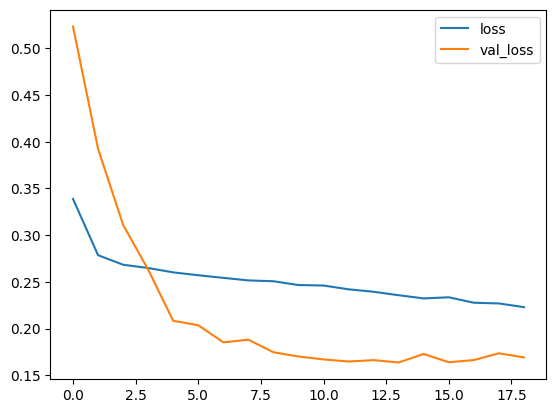

In [17]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()

In [19]:
from functions.tools import metrics

177/177 [==============================] - 4s 8ms/step
Best Threshold=0.126280
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      5164
           1       0.57      0.96      0.72       474

    accuracy                           0.94      5638
   macro avg       0.78      0.95      0.84      5638
weighted avg       0.96      0.94      0.94      5638

Specificity 0.9335786212238575
Sensitivity 0.9620253164556962
ROC score 0.9690138152153663
AP 0.6519827478821639
PPV 0.5707133917396746
NPV 0.9962802231866088
BS 0.03912663524818696
AUPRC 0.6519827478821639


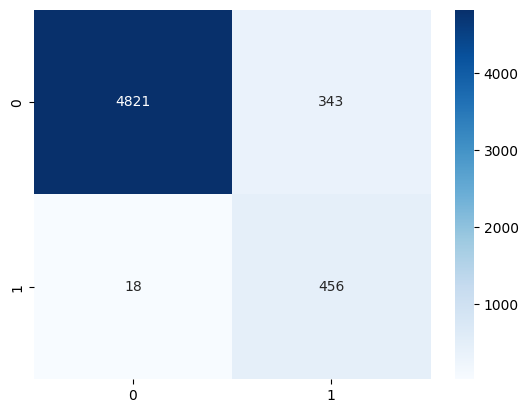

In [20]:
predictions = model.predict(X_test)

metrics(predictions, y_test)

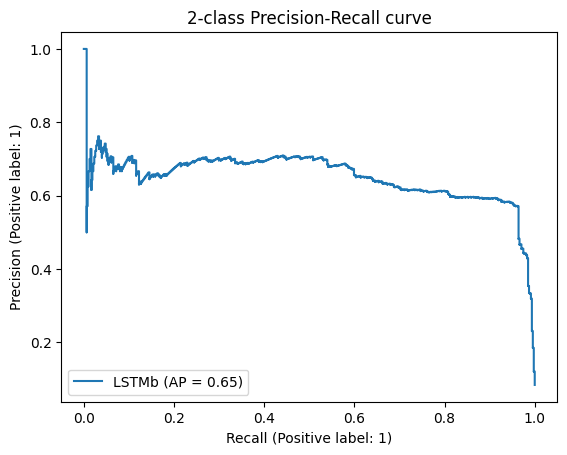

In [22]:
from sklearn.metrics import PrecisionRecallDisplay

prcurve = PrecisionRecallDisplay.from_predictions(y_test, predictions, name="LSTMb")
_ = prcurve.ax_.set_title("2-class Precision-Recall curve")


In [24]:
#This bootstraps the hold out set
from functions.bootstrap import *

print('summarised')
score, ci_lower, ci_upper, scores = score_ci(y_test, list(predictions.reshape(5638)), score_fun=rc)
print('auroc')
print(round(score,2),'(',round(ci_lower,2),'-',round(ci_upper,2),')')
score, ci_lower, ci_upper, scores = score_ci(y_test, list(predictions.reshape(5638)), score_fun=ap)
print('auprc')
print(round(score,2),'(',round(ci_lower,2),'-',round(ci_upper,2),')')

summarised
auroc
0.97 ( 0.96 - 0.97 )
auprc
0.65 ( 0.6 - 0.7 )
